In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.optim as optim
from diffusers import StableDiffusionPipeline
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

In [ ]:
class TextualInversionTrainer:
    def __init__(self, model_id="stabilityai/stable-diffusion-2-1-base", placeholder_token="<rare-object>", initializer_token="object"):
        # Clear CUDA cache
        torch.cuda.empty_cache()

        # Use float32 to avoid potential gradient issues
        torch.set_default_dtype(torch.float32)

        # Load model
        self.pipe = StableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=torch.float32,
            safety_checker=None  # Disable safety checker
        ).to("cuda")

        # Enable memory efficient attention
        self.pipe.enable_attention_slicing()

        # Extract model components
        self.tokenizer = self.pipe.tokenizer
        self.text_encoder = self.pipe.text_encoder
        self.unet = self.pipe.unet
        self.vae = self.pipe.vae
        self.scheduler = self.pipe.scheduler

        # Freeze most model components
        self.text_encoder.requires_grad_(False)
        self.unet.requires_grad_(False)
        self.vae.requires_grad_(False)

        # Get text embeddings
        text_embeddings = self.text_encoder.get_input_embeddings()

        # Add new token
        self.tokenizer.add_tokens(placeholder_token)
        self.text_encoder.resize_token_embeddings(len(self.tokenizer))

        # Get token IDs
        token_ids = self.tokenizer.encode(initializer_token, add_special_tokens=False)
        if not token_ids:
            raise ValueError(f"Could not find token id for {initializer_token}")

        # Get new token ID
        target_token_id = self.tokenizer.convert_tokens_to_ids(placeholder_token)
        initializer_token_id = token_ids[0]

        # Initialize new embedding with requires_grad
        with torch.no_grad():
            device = text_embeddings.weight.device
            initializer_token_tensor = torch.tensor([initializer_token_id], device=device, dtype=torch.long)

            # Get initializer embedding
            initializer_embeds = text_embeddings(initializer_token_tensor)

            # Create a new embedding that requires gradient
            new_embedding = initializer_embeds.clone().detach()

        # Create a new parameter for the embedding that requires gradient
        self.new_param = nn.Parameter(new_embedding)
        text_embeddings.weight[target_token_id] = self.new_param

        # Optimizer for new embedding
        self.embedding_optimizer = optim.AdamW(
            [{'params': [self.new_param]}],
            lr=5e-4
        )

        self.placeholder_token = placeholder_token
        self.target_token_id = target_token_id

    def prepare_image_dataset(self, images, img_size=(256, 256)):
        """Prepare images for training"""
        preprocess = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            # Normalize to [-1, 1] range
            transforms.Normalize([0.5], [0.5])
        ])
        return [preprocess(img) for img in images]

    def train(self, images, num_epochs=100):
        """Train textual inversion"""
        # Prepare images
        training_images = self.prepare_image_dataset(images)

        # Loss tracking
        losses = []

        # Ensure everything is on CUDA
        device = torch.device("cuda")

        for epoch in range(num_epochs):
            torch.cuda.empty_cache()
            epoch_loss = 0

            for image_tensor in training_images:
                # Clear previous gradients
                self.embedding_optimizer.zero_grad()

                # Ensure image tensor is correct shape and on device
                image_tensor = image_tensor.unsqueeze(0).to(device)

                # Create prompt
                prompt = f"a photo of {self.placeholder_token}"

                # Encode text
                text_inputs = self.tokenizer(
                    prompt,
                    padding="max_length",
                    max_length=self.tokenizer.model_max_length,
                    truncation=True,
                    return_tensors="pt"
                ).to(device)

                # Encode image to latent space
                with torch.no_grad():
                    # Encode to latents
                    latents = self.vae.encode(image_tensor).latent_dist.sample()
                    latents = latents * 0.18215

                # Ensure latents have correct shape and type
                if latents.dim() == 3:
                    latents = latents.unsqueeze(0)
                if latents.shape[1] != 4:
                    latents = latents.expand(-1, 4, -1, -1)

                # Sample noise
                noise = torch.randn_like(latents)
                timesteps = torch.randint(
                    0,
                    self.scheduler.config.num_train_timesteps,
                    (latents.shape[0],),
                    device=device,
                    dtype=torch.long
                )

                # Add noise
                noisy_latents = self.scheduler.add_noise(latents, noise, timesteps)

                # Encode text with attention mask
                with torch.enable_grad():
                    encoder_hidden_states = self.text_encoder(
                        text_inputs.input_ids,
                        attention_mask=text_inputs.attention_mask
                    )[0]

                # Predict noise
                model_pred = self.unet(
                    noisy_latents,
                    timesteps,
                    encoder_hidden_states=encoder_hidden_states
                ).sample

                # Compute loss
                loss = nn.functional.mse_loss(model_pred, noise, reduction="mean")

                # Backward pass
                loss.backward(retain_graph=True)  # Retain graph for multiple backward passes

                # Optimize
                self.embedding_optimizer.step()

                epoch_loss += loss.item()

            # Calculate average loss
            avg_loss = epoch_loss / len(training_images)
            losses.append(avg_loss)
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

        return losses

    def generate_images(self, prompts, num_images=1):
        """Generate images with learned embedding"""
        images = []
        for prompt in prompts:
            # Generate images
            image = self.pipe(
                prompt,
                num_inference_steps=30,
                guidance_scale=7.5,
                num_images_per_prompt=num_images
            ).images
            images.extend(image)
        return images

    def plot_training_loss(self, losses):
        """Plot training loss"""
        plt.figure(figsize=(10, 5))
        plt.plot(losses)
        plt.title('Textual Inversion Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.tight_layout()
        plt.show()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Epoch 1/350, Loss: 0.2092
Epoch 2/350, Loss: 0.2832
Epoch 3/350, Loss: 0.1838
Epoch 4/350, Loss: 0.2170
Epoch 5/350, Loss: 0.1927
Epoch 6/350, Loss: 0.0430
Epoch 7/350, Loss: 0.1941
Epoch 8/350, Loss: 0.2144
Epoch 9/350, Loss: 0.1124
Epoch 10/350, Loss: 0.2874
Epoch 11/350, Loss: 0.1472
Epoch 12/350, Loss: 0.0505
Epoch 13/350, Loss: 0.1686
Epoch 14/350, Loss: 0.1531
Epoch 15/350, Loss: 0.1529
Epoch 16/350, Loss: 0.0687
Epoch 17/350, Loss: 0.1453
Epoch 18/350, Loss: 0.0821
Epoch 19/350, Loss: 0.2699
Epoch 20/350, Loss: 0.2981
Epoch 21/350, Loss: 0.1350
Epoch 22/350, Loss: 0.1083
Epoch 23/350, Loss: 0.4099
Epoch 24/350, Loss: 0.1723
Epoch 25/350, Loss: 0.2169
Epoch 26/350, Loss: 0.2160
Epoch 27/350, Loss: 0.0451
Epoch 28/350, Loss: 0.1887
Epoch 29/350, Loss: 0.2930
Epoch 30/350, Loss: 0.2451
Epoch 31/350, Loss: 0.1569
Epoch 32/350, Loss: 0.2109
Epoch 33/350, Loss: 0.1883
Epoch 34/350, Loss: 0.2040
Epoch 35/350, Loss: 0.1680
Epoch 36/350, Loss: 0.2537
Epoch 37/350, Loss: 0.0886
Epoch 38/3

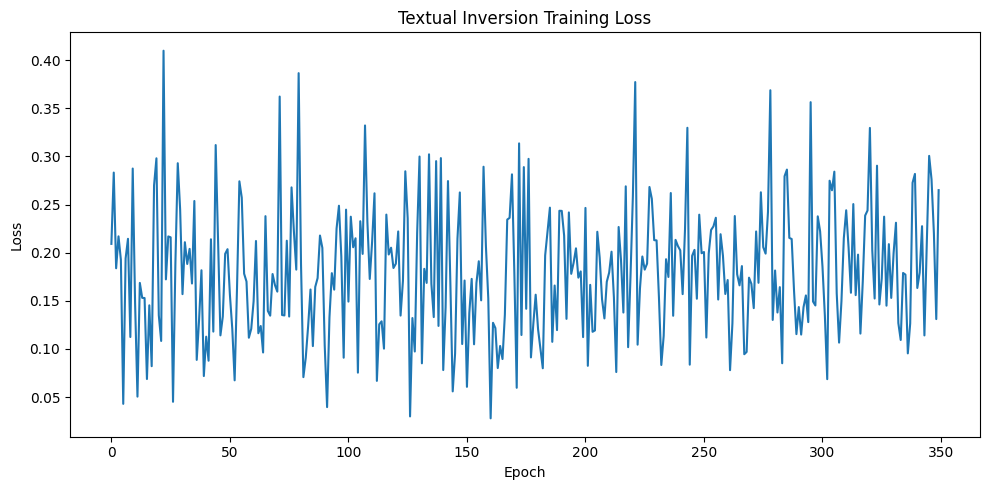

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
def main():
    # Try to load 10-20 images or create placeholders
    from PIL import ImageFile
    ImageFile.LOAD_TRUNCATED_IMAGES = True

    images = []
    for i in range(2, 7):
        image_path = None
        # Case-insensitive extension check
        for ext in ['jpeg', 'jpg', 'png', 'JPEG', 'JPG', 'PNG']:
            potential_path = f'/content/r{i}.{ext}'
            if os.path.exists(potential_path):
                image_path = potential_path
                break

        try:
            if image_path:
                image = Image.open(image_path).convert('RGB')  # Force RGB
            else:
                raise FileNotFoundError
        except Exception as e:
            print(f"Error loading r{i}: {str(e)}. Using placeholder.")
            image = Image.new('RGB', (256, 256), (255, 255, 255))

        images.append(image)

    # Initialize trainer
    trainer = TextualInversionTrainer(
        placeholder_token="<ronaldo-star>",
        initializer_token="footballer"
    )

    # Train
    losses = trainer.train(images, num_epochs=350)

    # Plot loss
    trainer.plot_training_loss(losses)

    # Generate images
    prompts = [
        f"a photo of {trainer.placeholder_token} in a garden",
        f"a creative portrait with {trainer.placeholder_token}"
    ]
    generated_images = trainer.generate_images(prompts)

    # Save generated images
    for i, img in enumerate(generated_images):
        img.save(f"generated_image_{i}.png")

if __name__ == "__main__":
    main()